## Prototyping deregistration for MATE-tracked data

### Prep

In [83]:
### Imports

import numpy as np
import matplotlib.pyplot as plt

from skimage import io

In [ ]:
### Parameters

# Target time course paths
target_tc = r'Z:\DBIO_WongGroup_1\Zimeng\_MATE\20241025_multipos_980\MAX_20241025_position_1.tif'  

# Target mate_coords paths
target_coords = r'Z:\DBIO_WongGroup_1\Zimeng\_MATE\20241025_multipos_980\prescans\mate_coords.txt'  

# Prescan shape
#prescan_shape = np.array([21, 512, 512])
prescan_shape = np.array([200, 512])  # Focusing purely on xy for now

### Load data

In [112]:
### Load z-projected time course

tc = io.imread(target_tc)
#tc = np.moveaxis(tc, 1, 0)

tc = tc[None,:,:,:]

print(tc.shape, tc.dtype)

(1, 88, 660, 2124) uint8


(88, 2) int32


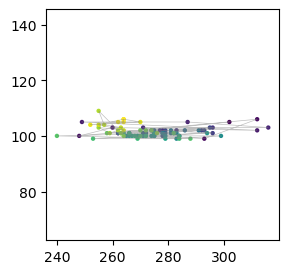

In [113]:
### Load mate_coords.txt

# Load coords
coords = np.loadtxt(
    target_coords, delimiter="\t", skiprows=1, usecols=[0,1,2])
coords = np.round(coords, 0).astype(int)

# Grab only relevant data (xy only, and before MATE failed)
coords = coords[0::3, 1:]
print(coords.shape, coords.dtype)

# Plot the loaded coords
plt.figure(figsize=(3, 3))
plt.plot(
    coords[:, 1], coords[:, 0],
    c="0.5", alpha=0.5, lw=0.5)
plt.scatter(
    coords[:, 1], coords[:, 0],
    c=np.arange(coords.shape[0]), cmap='viridis',
    s=10, edgecolors='none')
plt.axis('equal')
plt.show()

# ->> Note that the first move happens *before* any tc frames are acquired and thus
#     should not be considered when determining image positions!

### Create de-registered stack

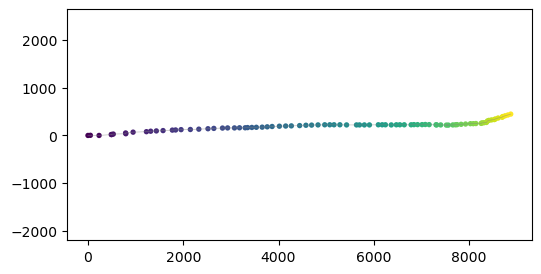

In [114]:
### Calculate deregistered coordinates

# Get offsets and cumulative offset
offsets = coords - (prescan_shape // 2)
coords_dr = np.cumsum(offsets, axis=0) - offsets[0]

# Convert from prescan to high-res scaling
#coords_dr = coords_dr / prescan_shape[1] * tc.shape[-2] #for chick node 3x
coords_dr = coords_dr / prescan_shape * tc.shape[-2:]
coords_dr = coords_dr.astype(int)

# Show result
plt.figure(figsize=(6, 3))
plt.plot(
    coords_dr[:, 1], coords_dr[:, 0], c="0.5", alpha=0.5, lw=0.5)
plt.scatter(
    coords_dr[:, 1], coords_dr[:, 0],
    c=np.arange(coords.shape[0]), cmap='viridis',
    s=15, edgecolors='none')
plt.axis('equal')
plt.show()

(1, 88, 1108, 10998) uint8


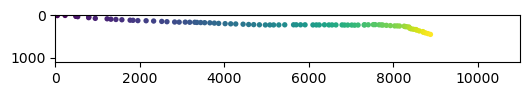

In [115]:
### Prepare the de-registered array

# Get size of entire area
min_corner = coords_dr.min(axis=0)
max_corner = coords_dr.max(axis=0) + tc.shape[-2:]
dr_size = max_corner - min_corner

# Create empty array
tc_dr = np.zeros((
    tc.shape[0],  # channels
    tc.shape[1],  # time points
    dr_size[0],   # y
    dr_size[1]    # x
), dtype=np.uint8)
print(tc_dr.shape, tc_dr.dtype)

# Move coords based on entire area's origins
coords_dr_fin = coords_dr - min_corner

# Show
plt.figure(figsize=(6, 3))
plt.imshow(tc_dr[0, 0], cmap="gray", vmin=-1)
plt.scatter(
    coords_dr_fin[:, 1], coords_dr_fin[:, 0],
    c=np.arange(coords.shape[0]), cmap='viridis',
    s=15, edgecolors='none')
plt.show()

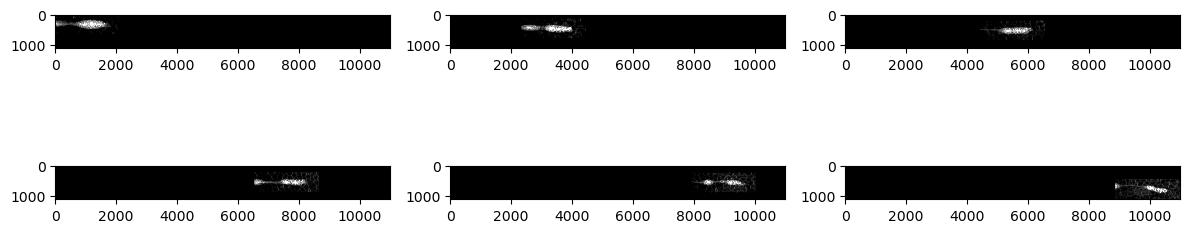

In [82]:
### Paste in the image data

# Paste
for tp in range(tc.shape[1]):
    y, x = coords_dr_fin[tp]
    tc_dr[:, tp, y:y+tc.shape[-2], x:x+tc.shape[-1]] = tc[:, tp, :, :] #de registered
    #tc_dr[:, tp:, y:y+tc.shape[-2], x:x+tc.shape[-1]] = tc[:, tp:tp+1, :, :] #keeps 'old' frame
    
# Show result
fig, ax = plt.subplots(2, 3, figsize=(12, 4))
for tp,axis in zip(np.linspace(0, tc.shape[1]-1, 6).astype(int), ax.ravel()):
    axis.imshow(tc_dr[0, tp], cmap="gray", vmin=10, vmax=90)
plt.tight_layout()
plt.show()

### Save results

In [ ]:
outpath = target_tc[:-4] + "_dereg.tif"

io.imsave(outpath, np.moveaxis(tc_dr, 1, 0), check_contrast=False)

For border

In [ ]:
for tp in range(tc.shape[1]):
    y, x = coords_dr_fin[tp]
    frame_height, frame_width = tc.shape[-2], tc.shape[-1]
    
    # Paste the frame
    tc_dr[:, tp, y:y+frame_height, x:x+frame_width] = tc[:, tp, :, :]
    
    # Draw the white outline (border thickness of 1 pixel)
    tc_dr[:, tp, y:y+10, x:x+frame_width] = 255  # Top border
    tc_dr[:, tp, y+frame_height-10:y+frame_height, x:x+frame_width] = 255  # Bottom border
    tc_dr[:, tp, y:y+frame_height, x:x+10] = 255  # Left border
    tc_dr[:, tp, y:y+frame_height, x+frame_width-10:x+frame_width] = 255  # Right border

# Show result
fig, ax = plt.subplots(2, 3, figsize=(12, 4))
for tp,axis in zip(np.linspace(0, tc.shape[1]-1, 6).astype(int), ax.ravel()):
    axis.imshow(tc_dr[0, tp], cmap="gray", vmin=10, vmax=90)
plt.tight_layout()
plt.show()

In [ ]:
outpath = target_tc[:-4] + "_dereg_border.tif"

io.imsave(outpath, np.moveaxis(tc_dr, 1, 0), check_contrast=False)